In [1]:
import pandas as pd; import geopandas as gpd; import seaborn as sns
from shapely.geometry import Point;
import fiona, sys, json, datapackage;
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = gpd.read_file('/Users/jenningsa/data/countries_simplified.geojson')
df = df.fillna(0).rename(columns={'id':'country'}).set_index('country')
df.head(2)

,ISO_A3,Responses,geometry
country,,,
Aruba,ABW,0.0,"POLYGON ((-69.99694 12.57758, -69.92467 12.519..."
Afghanistan,AFG,0.0,"POLYGON ((71.04980 38.40866, 71.35816 38.25126..."


<AxesSubplot:>

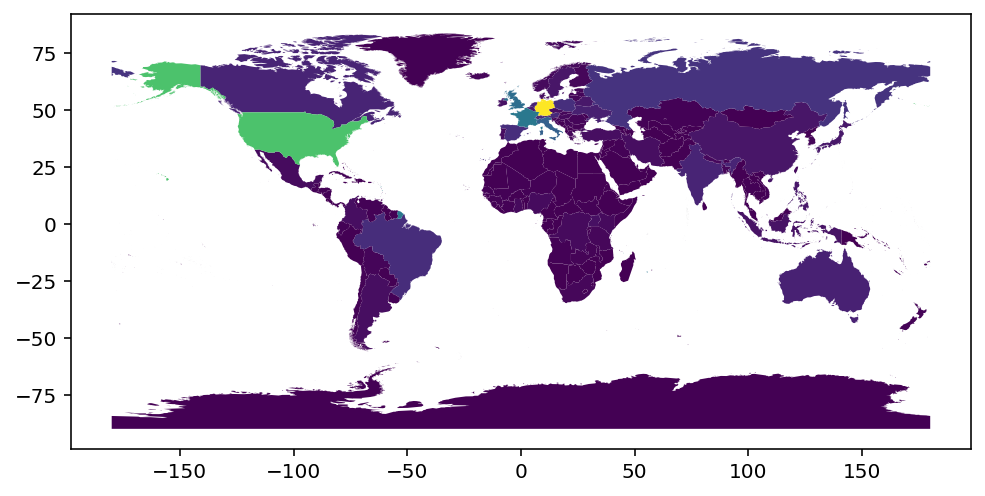

In [3]:
df.plot(column='Responses', figsize=(10,4))

In [4]:
country_region_mapping = pd.read_csv('/Users/jenningsa/data/country_regions.csv')[['Alpha-3 Code','OSMF Region','Also Known As']].rename(columns={'Alpha-3 Code':'ISO_A3'})
country_region_mapping.head(2)


,ISO_A3,OSMF Region,Also Known As
0,BWA,Africa-angl,Africa-anglophone
1,BDI,Africa-angl,Africa-anglophone


In [5]:
#Clean the OSMF Region Name to match the survey responses: 
country_region_mapping['OSMF Region'].unique()

array(['Africa-angl', 'Africa-rom', 'Americas', 'Australia', 'Austria',
       'Belarus', 'Belgium', 'Brazil', 'Canada', 'China', 'EAsia/Oceania',
       'EU', 'Europe', 'France', 'Germany', 'India', 'Indonesia', 'Italy',
       'Japan', 'Middle East', 'Netherlands', 'Philippines', 'Poland',
       'Russian Federation', 'S&W Asia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom', 'United States', nan], dtype=object)

<AxesSubplot:>

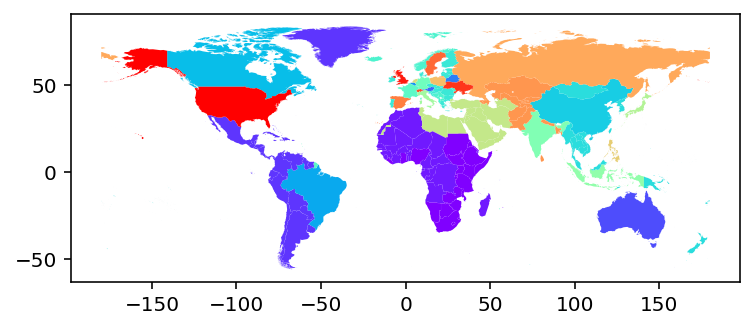

In [6]:
df2 = df.merge(country_region_mapping, on='ISO_A3', how='inner')
countries = df2[~pd.isnull(df2['OSMF Region'])]
countries.plot(column='OSMF Region',cmap=sns.color_palette('rainbow',as_cmap=True))

In [16]:
with open('osmf-survey-response-counts-by-country.geojson','w') as outFile:
    outFile.write(countries.to_json())

<AxesSubplot:>

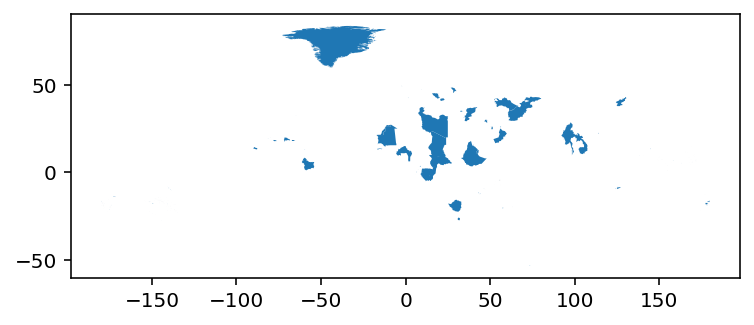

In [17]:
survey_regions_no_responses = countries[countries.Responses<1].dissolve(by='OSMF Region',aggfunc='sum')
survey_regions_no_responses.plot()

<AxesSubplot:>

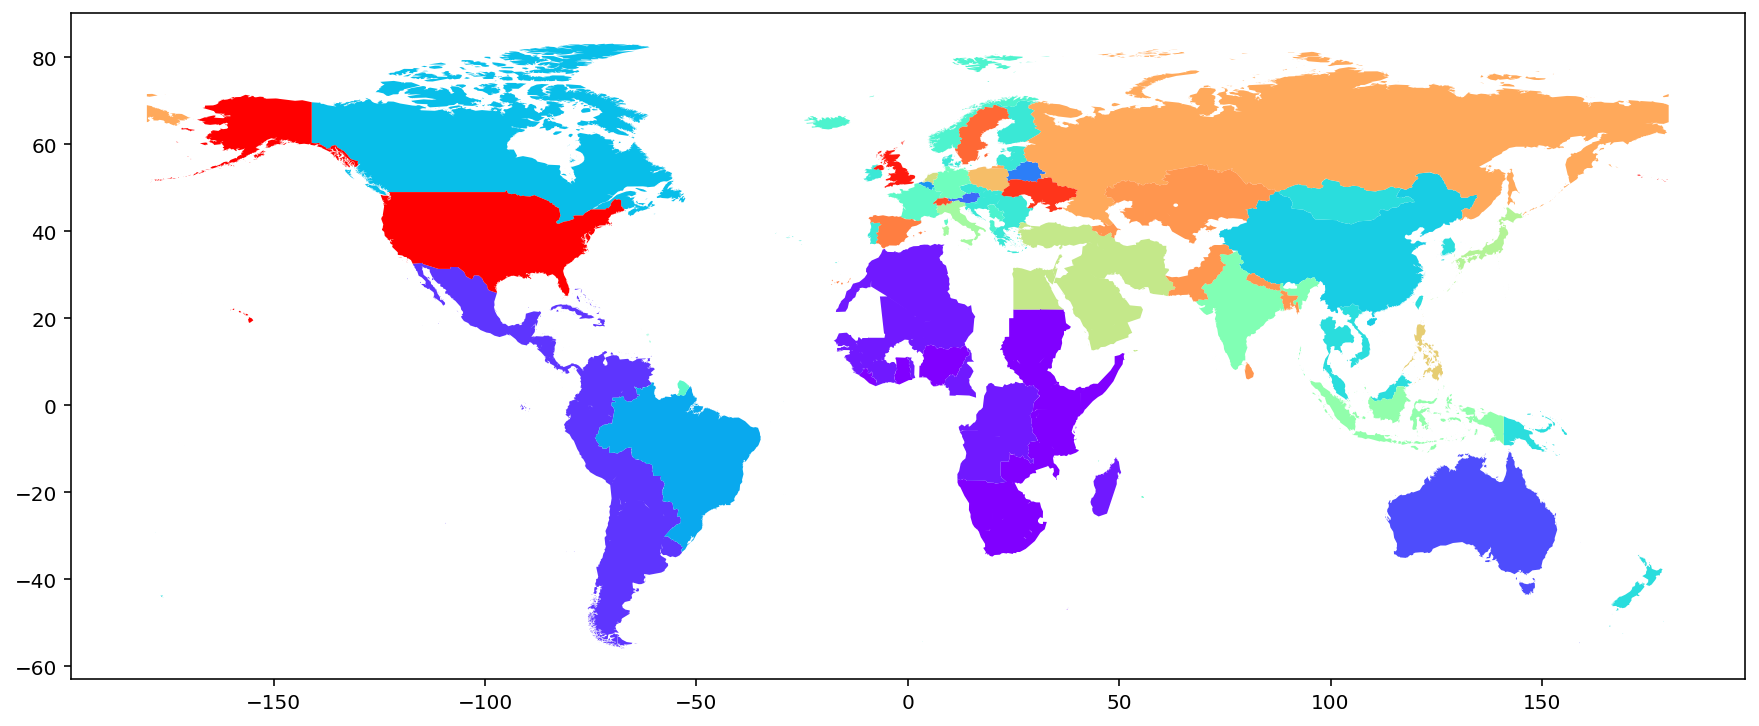

In [18]:
survey_regions = countries[countries.Responses>0].dissolve(by='OSMF Region',aggfunc='sum')
survey_regions.plot(figsize=(15,8), cmap=sns.color_palette('rainbow',as_cmap=True))

In [20]:
survey_regions.head()

,geometry,Responses
OSMF Region,,
Africa-angl,"MULTIPOLYGON (((37.86378 -46.94085, 37.61883 -...",83.0
Africa-rom,"MULTIPOLYGON (((49.84449 -17.07220, 49.85727 -...",34.0
Americas,"MULTIPOLYGON (((-67.56766 -55.80718, -67.47201...",80.0
Australia,"MULTIPOLYGON (((158.86573 -54.74993, 158.85255...",38.0
Austria,"POLYGON ((15.16179 48.93722, 16.08535 48.74287...",47.0


In [35]:
feedback = pd.read_csv('/Users/jenningsa/data/feedback_by_region.csv')
feedback_gb_region_mean = feedback.groupby('Country/Region').aggregate('mean').rename(columns=
    {'Code Of Conduct':'CoC-mean', 'Fundraising':'Fundraising-mean','Software Investments':'Software Investments-mean',
     'iD':'iD-mean', 'Microgrants':'Microgrants-mean'})
feedback_gb_region_std = feedback.groupby('Country/Region').aggregate('std').rename(columns=
    {'Code Of Conduct':'CoC-std', 'Fundraising':'Fundraising-std','Software Investments':'Software Investments-std',
     'iD':'iD-std', 'Microgrants':'Microgrants-std'})
feedback_gb_region = feedback_gb_region_mean.join(feedback_gb_region_std)
feedback_gb_region.head()

,CoC-mean,Fundraising-mean,Software Investments-mean,iD-mean,Microgrants-mean,CoC-std,Fundraising-std,Software Investments-std,iD-std,Microgrants-std
Country/Region,,,,,,,,,,
Africa-angl,3.975904,4.397590,4.265060,4.108434,4.289157,0.962414,0.840147,0.884616,1.000147,0.956749
Africa-rom,3.970588,4.352941,4.147059,3.823529,4.205882,0.904041,0.917254,1.104601,0.968303,1.094875
Americas,3.987500,4.387500,4.412500,3.962500,4.050000,1.141770,0.787461,0.757974,1.130069,0.855363
Australia,3.894737,4.105263,4.236842,4.026316,4.131579,1.060073,0.923843,0.786171,1.173741,1.017975
Austria,3.936170,4.021277,4.255319,4.510638,3.893617,1.030075,0.896597,0.736268,0.830724,0.865625


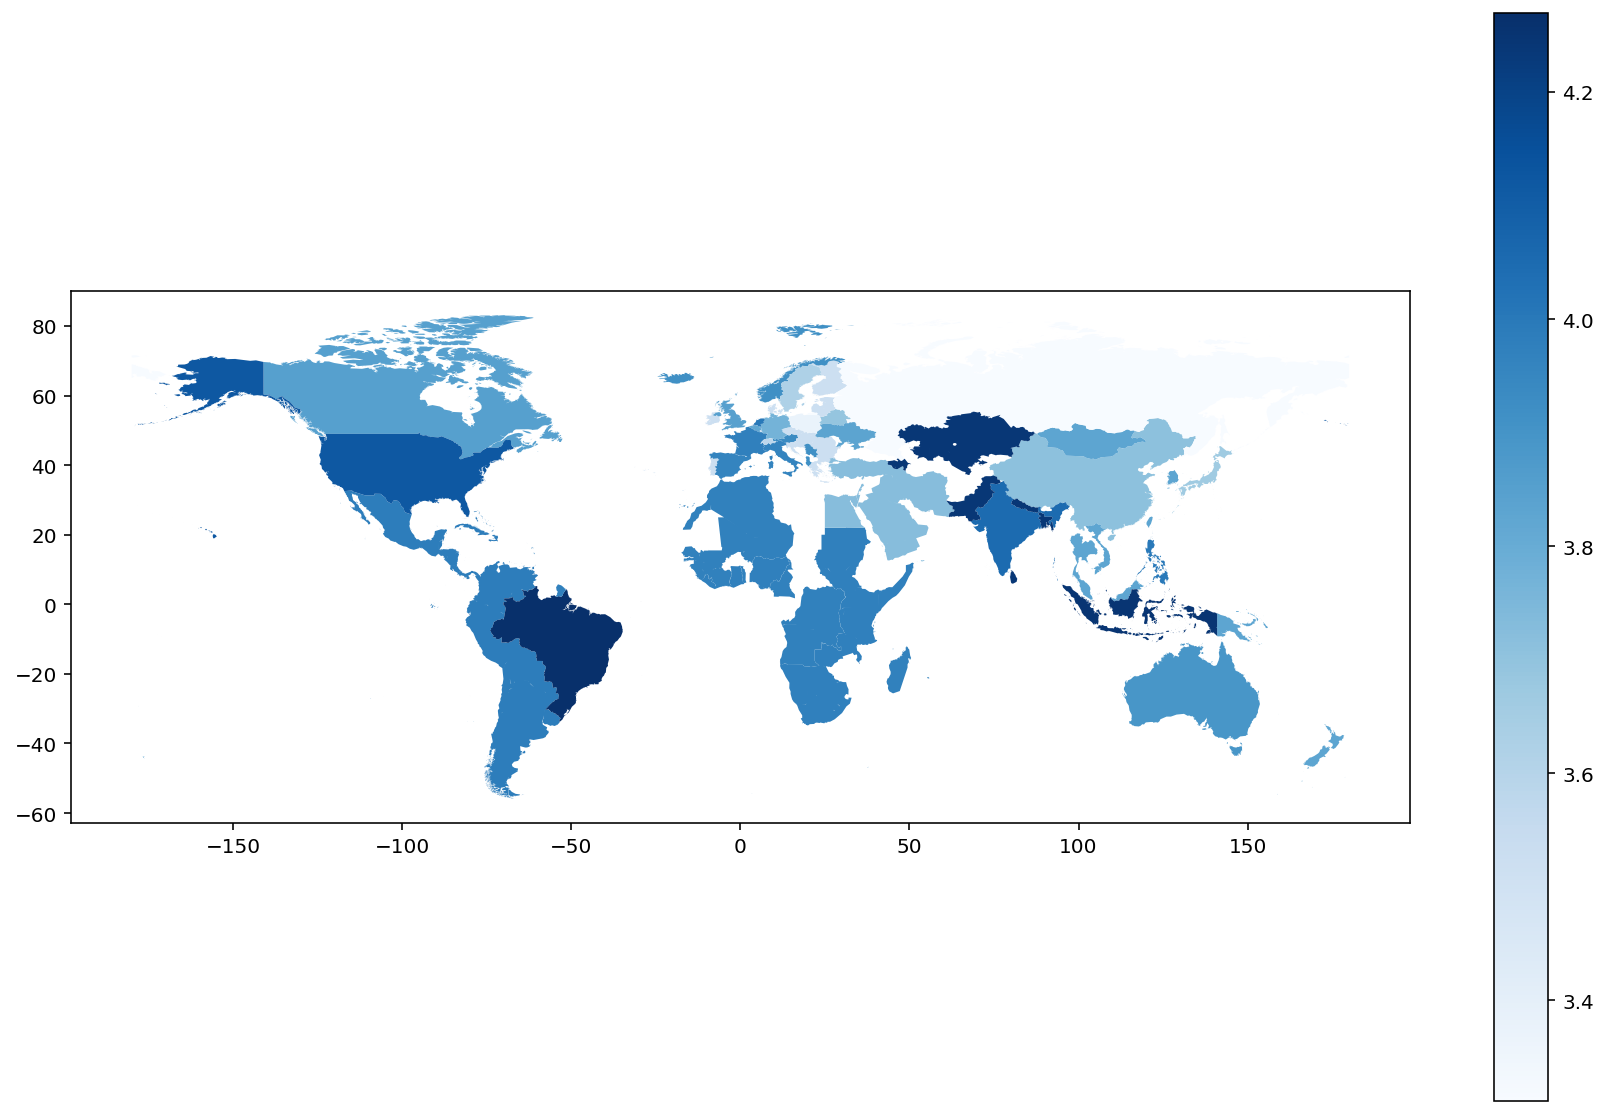

In [38]:
with_feedback = survey_regions.join(feedback_gb_region)
ax = with_feedback.plot(column='CoC-mean', figsize=(15,10),
                        cmap=sns.color_palette('Blues',as_cmap=True), legend=True)

In [39]:
with open('osmf-survey-feedback-responses.geojson','w') as outFile:
    outFile.write(with_feedback.to_json())